<a href="https://colab.research.google.com/github/chang-heekim/Oxford-Pet-Dataset/blob/main/Oxford_Pet_Dataset_Semantic_Segmentation_3_Class_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Necessary Library

In [ ]:
import numpy as np
import pandas as pd
import os 
import math
import random

from glob import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, BatchNormalization, Dropout, Activation, MaxPool2D, concatenate
from keras.models import Model
from PIL import Image

# Preprocessing Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/oxford_pet/annotations/list.txt', skiprows=6, delimiter=' ', header=None)
df.columns = ['file_name', 'id', 'species', 'breed']
df.head()

,file_name,id,species,breed
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [ ]:
image_dir = '/content/drive/MyDrive/dataset/oxford_pet/images/'
mask_dir = '/content/drive/MyDrive/dataset/oxford_pet/annotations/trimaps/'

In [ ]:
image_files = glob(image_dir + '*.jpg')
mask_files = glob(mask_dir + '*.png')

In [ ]:
images = []
masks = []

for image_file in image_files:
    mask_file = image_file.replace(image_dir, mask_dir).replace('.jpg', '.png')

    image = Image.open(image_file)
    image_mode = image.mode
    image = tf.image.resize(np.array(image), (224, 224))
    images.append(image)
    if image_mode != 'RGB':
        images.pop()
        continue

    if mask_file not in mask_files:
        images.pop()
    else:
        mask = Image.open(mask_file)
        mask = np.expand_dims(np.array(mask), -1)
        mask = mask - 1
        mask = tf.image.resize(mask, (224, 224))
        masks.append(mask)

images = np.array(images) / 255.
masks = np.array(masks) 

print(len(images), len(masks))

7378 7378


In [ ]:
train_size = int(len(images) * 0.9)
val_size = len(images) - train_size

train_batch_size = 16
val_batch_size = 16

dataset = tf.data.Dataset.from_tensor_slices((images, masks))

train_dataset = dataset.take(train_size)
val_dataset = dataset.take(val_size)

train_loader = train_dataset.batch(train_batch_size, drop_remainder=True).shuffle(1024)
val_loader = val_dataset.batch(val_batch_size, drop_remainder=True)

In [ ]:
for sample_batch in train_dataset:
    print(sample_batch[0])
    print(sample_batch[0].shape)
    print(sample_batch[1].shape)
    break

tf.Tensor(
[[[0.74899083 0.67448103 0.6823242 ]
  [0.7683836  0.6989946  0.70513076]
  [0.7485595  0.6858144  0.68973595]
  ...
  [0.93569535 0.8814851  0.9217774 ]
  [0.93392617 0.8711811  0.9143183 ]
  [0.9084113  0.8624287  0.8888035 ]]

 [[0.75593114 0.68142134 0.6892645 ]
  [0.7630452  0.69365615 0.69979244]
  [0.74457157 0.6818265  0.68574804]
  ...
  [0.92742354 0.8732133  0.9118249 ]
  [0.90952647 0.8467814  0.88823795]
  [0.84654987 0.8005673  0.8266981 ]]

 [[0.7629352  0.6884254  0.69626856]
  [0.7498374  0.6804484  0.68658465]
  [0.7313125  0.6685674  0.672489  ]
  ...
  [0.91031957 0.8561093  0.8924801 ]
  [0.8639633  0.8012182  0.8404339 ]
  [0.80513924 0.75436735 0.7825677 ]]

 ...

 [[0.68362725 0.4119186  0.30155435]
  [0.6778187  0.40611002 0.29574576]
  [0.66404194 0.39233327 0.281969  ]
  ...
  [0.7713403  0.52428144 0.4654579 ]
  [0.7414331  0.4937415  0.43681616]
  [0.75104475 0.50094986 0.4368669 ]]

 [[0.661155   0.38216352 0.28244355]
  [0.6664493  0.38745788 0

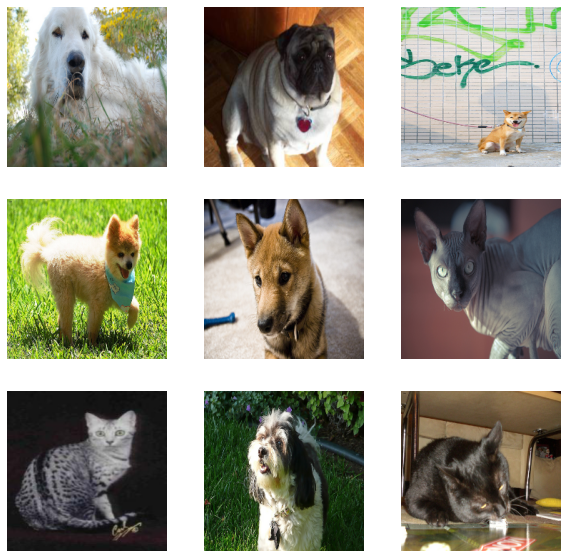

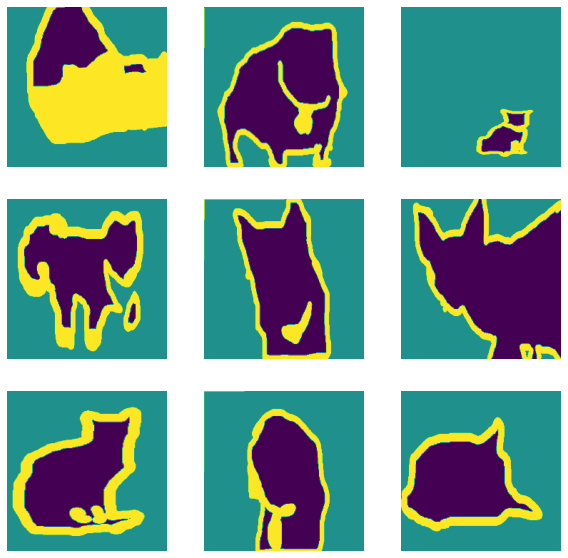

In [ ]:
sample = next(iter(train_loader))
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample[0][i])
    plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(tf.reshape(sample[1][i], (224, 224)))
    plt.axis('off')
plt.show()

# Define UNet

In [ ]:
def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def unet():
    inputs = Input((224, 224, 3))
    
    c1 = conv2d_block(inputs, 64)
    p1 = MaxPool2D((2,2))(c1)
    p1 = Dropout(0.5)(p1)
    
    c2 = conv2d_block(p1, 128)
    p2 = MaxPool2D((2,2))(c2)
    p2 = Dropout(0.5)(p2)
    
    c3 = conv2d_block(p2, 256)
    p3 = MaxPool2D((2,2))(c3)
    p3 = Dropout(0.5)(p3)

    c4 = conv2d_block(p3, 512)
    p4 = MaxPool2D((2,2))(c4)
    p4 = Dropout(0.5)(p4)

    c5 = conv2d_block(p4, 1024)
    
    u6 = Conv2DTranspose(512, 2, 2, output_padding=(0, 0))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.5)(u6)
    c6 = conv2d_block(u6, 512)
    
    u7 = Conv2DTranspose(256, 2, 2, output_padding=(0, 0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.5)(u7)
    c7 = conv2d_block(u7, 256)
    
    u8 = Conv2DTranspose(128, 2, 2, output_padding=(0, 0))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.5)(u8)
    c8 = conv2d_block(u8, 128)
    
    u9 = Conv2DTranspose(64, 2, 2, output_padding=(0, 0))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.5)(u9)
    c9 = conv2d_block(u9, 64)
    
    outputs = Conv2D(3, 1, activation='softmax')(c9)
    model = Model(inputs, outputs)
    return model

# Define IOU & Dice Loss Function

In [ ]:
def iou(targets, preds):
    smooth = 1e-5

    preds = tf.argmax(preds, -1)
    preds = tf.expand_dims(preds, -1)
    preds = preds.numpy()
    targets = targets.numpy()

    intersection = np.logical_and(targets, preds)
    union = np.logical_or(targets, preds)
    iou_score = np.sum(intersection) / np.sum(union)

    return iou_score

def dice_coef(targets, preds):
    smooth = 1e-5

    preds = preds.numpy()
    targets = targets.numpy()

    intersection = np.logical_and(targets, preds)
    union = np.sum(np.logical_or(targets, targets)) + np.sum(np.logical_or(preds, preds))
    dice = (2. * np.sum(intersection) + smooth) / (np.sum(union) + smooth)
    return dice
    

def dice_loss(targets, preds):
    return 1 - dice_coef(targets, preds)

def ce_dice_loss(targets, preds):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    loss = 1. * loss_fn(targets, preds) + 1. * dice_loss(targets, preds)
    return loss

# Define Model & Loss & Optimizer

In [ ]:
lr = 1e-2
epochs = 15

model = unet()
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
    loss=ce_dice_loss, 
    metrics=[iou],
    run_eagerly=True
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Training

In [ ]:
hist = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=epochs
)

Epoch 1/15
415/415 [==============================] - 231s 524ms/step - loss: 0.5983 - iou: 0.7208 - val_loss: 0.9248 - val_iou: 0.6520
Epoch 2/15
415/415 [==============================] - 220s 523ms/step - loss: 0.5308 - iou: 0.7467 - val_loss: 0.6238 - val_iou: 0.7411
Epoch 3/15
415/415 [==============================] - 218s 521ms/step - loss: 0.4254 - iou: 0.7890 - val_loss: 0.5032 - val_iou: 0.7893
Epoch 4/15
415/415 [==============================] - 218s 520ms/step - loss: 0.3283 - iou: 0.8292 - val_loss: 0.3020 - val_iou: 0.8463
Epoch 5/15
415/415 [==============================] - 217s 520ms/step - loss: 0.2738 - iou: 0.8521 - val_loss: 0.2728 - val_iou: 0.8675
Epoch 6/15
415/415 [==============================] - 217s 520ms/step - loss: 0.2388 - iou: 0.8661 - val_loss: 0.2505 - val_iou: 0.8632
Epoch 7/15
415/415 [==============================] - 217s 520ms/step - loss: 0.2102 - iou: 0.8779 - val_loss: 0.4055 - val_iou: 0.7889
Epoch 8/15
415/415 [============================

# Visualization Loss & IOU

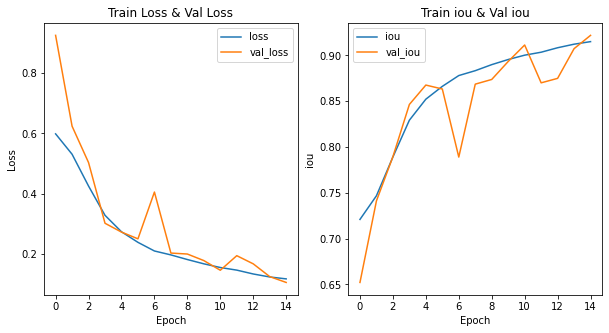

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Train Loss & Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.subplot(122)
plt.plot(hist.history['iou'], label='iou')
plt.plot(hist.history['val_iou'], label='val_iou')
plt.legend(loc='best')
plt.title('Train iou & Val iou')
plt.xlabel('Epoch')
plt.ylabel('iou')
plt.show()

# Test Model

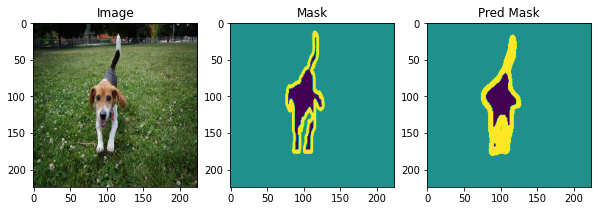

Iou:  0.7004544005102041


In [ ]:
img , mask = next(iter(val_loader))
img, mask = img[12:13], mask[12]

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(img[0])
plt.title('Image')
plt.subplot(132)
mask = tf.reshape(mask, (224, 224))
plt.imshow(mask)
plt.title('Mask')

pred = model.predict(img)
pred = tf.argmax(pred, -1)
pred = tf.reshape(pred, (224, 224))
plt.subplot(133)
plt.imshow(pred)
plt.title('Pred Mask')
plt.show()

print('Iou: ', iou(mask, pred))